# Beamforming in Photoacoustic Imaging
The aim of this assignment is to introduce and familiarize you with beamforming algorithms extensively used in photoacoustic imaging.

For a detailed description of the algorithms covered in this assignment, kindly refer to the following research paper:

> **Image improvement in linear-array photoacoustic imaging using high resolution coherence factor weighting technique**  
> [View the paper here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7422598/#:~:text=All%20the%20results%20indicate%20that,MV%20combined%20with%20conventional%20CF.)


## before you start
- I am taking this opportunity to explore this topic, and I am not an expert in beamforming. I provided `expected results` in this assignment, and this `expected results` is just the result I obtained. If you get a different result, and you believe what you have is a better solution, please email me. 
- The purpose of this assignment is to let you feel the excitement I felt while I was exploring this topic, and I do not want to fail any of you. So if you missed office hour and get stuck on this assignment. Please contact me immediately and we can schedule a time to meet. I can be reached by email: shiyuanduan2023@u.northwestern.edu, by phone/text: +15165669924, or by WeChat: dsydsy0124. 


## Enviorment Setup
This notebook only requires numpy, matplotlib, and scipy. If you are confident that they are installed properly, you can just run this notebook. If you want a venv, I recommand using conda by executing the following command on either Linux terminal, MacOS terminal, or Anaconda Prompt on Windows.

`conda create -n pat python=3.11 numpy matplotlib scipy`

# Simulation Setup

To explore beamforming algorithms, we need ultrasonic signals. **Matlab K-Wave** toolbox provides a powerful PAT(Photoacoustic Imaging Tomography) simulation. 

Our experiment utilizes a grid of dimensions (128, 256) as the foundational simulation landscape. The increments in both the x and y directions, `dX` and `dY`, are precisely 1e-3 meters. 3 sound wave sources are positioned vertically at the center. Positioned strategically at the grid's rightmost edge are 128 sensors, each diligently monitoring the sound waves' nuances. Pulses are generated by the three sources which is later captured by the linear transducer array. Below is an animation showing how signals are captured.


![sim_gif](simulation.gif)

## Signal Visualization

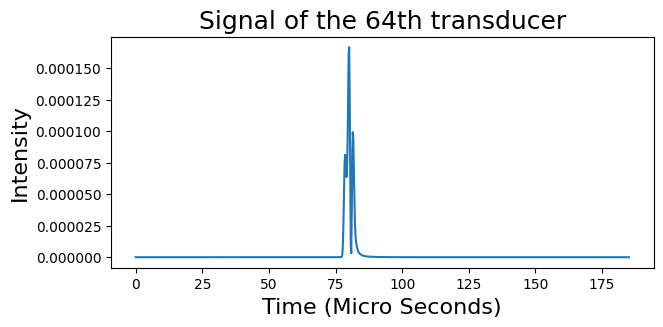

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

data = loadmat('sensor_data.mat')
sensor_data = data['sensor_data']
sensor_data = np.power(sensor_data, 2)

tick_data = np.arange(0, sensor_data.shape[1] * 0.194, 0.194)
plt.figure(figsize=(7, 3))

plt.plot(tick_data, sensor_data[64])


plt.xlabel('Time (Micro Seconds)', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.title('Signal of the 64th transducer', fontsize=18)
plt.show()


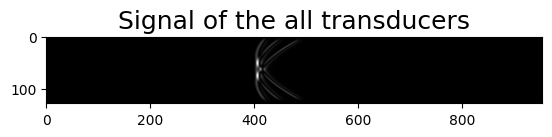

In [2]:
plt.title('Signal of the all transducers', fontsize=18)
plt.imshow(sensor_data, cmap='gray')

## Delay-And-Sum
The first algrithm we are implementing is the most basic beamforming algorithm: (DAS) Delay-And-Sum. The intuition is, in order to get the intensity of a specific pixel, we sum up all the values captured by the transducer array. However, based on the physical location of the pixel of interest, there will be time delays between signals captured by each transducer. Therefore, the mathmatical formulation is shown below. 
$$ y_{DAS}(k) = \sum_{i=1}^{M} x_i(k - \Delta_i) $$

### Step 1: Start from a Blank Canvas

**Notice**: *For better visualization, we choose a vertical canvas of size `(256, 128)`. The top left corner is indexed as `(0,0)` and the bottom right corner is indexed as `(255, 127)`.*

- **Canvas Orientation**: Vertical
- **Indexing**: 
  - Top Left Corner: `(0,0)`
  - Bottom Right Corner: `(255, 127)`

**Example Distance Calculation**:  
The distance between pixel `(0, 0)` and the first transducer (located at the bottom left) is calculated as `256 * dY = 255 * 1e-3`.


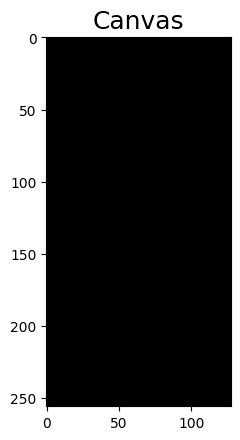

In [3]:
plt.title('Canvas', fontsize=18)
plt.imshow(np.zeros((256, 128)), cmap='gray')

### Step 2: Write a Helper Function for Distance Calculations

**Objective**: Create a function to calculate the distances from a given pixel index to all 128 transducers.

**Details**:
1. **Calculate Distances**: First, find the distances between the specified pixel and each of the 128 transducers.
2. **Travel Time**: Next, determine the time it would take for a wave to travel from the pixel to these transducers.
3. **Identify Indices for Summation**: Based on the travel times, ascertain the corresponding values (or indices) that will be included in the summation process.


In [4]:
def distance_to_transducers(x, y, dx=1e-3, dy=1e-3):

    
    distances = []
    # TODO: Implement the logic to calculate distances to transducers.
    # ---------------------------------------------------------------
    # Solution: 
    y_dir = (255 - y) * dy

    for i in range(128):
        x_dir = (x - i) * dx
        distances.append((y_dir)**2 + (x_dir)**2)
        
        
    # ---------------------------------------------------------------
    distances = np.array(distances)
    return np.sqrt(distances)


def get_time_delta_index(distances, sound_speed=1540, dt=194.8052):
    '''
    Helper function to convert distances to index between 0 to 954 (length of the signals). 
    '''
    times = distances / sound_speed

    return (times*1e9//dt).astype(int)

In [9]:
def delay_and_sum():
    canvas = np.zeros((256, 128))
    for x in range(128):
        for y in range(256):
            # TODO: Use DAS formula to populate each pixel on the canvas
            # ----------------------------------------------------------
            # Solution: 
            distances = distance_to_transducers(x, y)
            time_delta = get_time_delta_index(distances)
            values = sensor_data[np.arange(128),time_delta]
            canvas[y, x] = values.mean()
            # ----------------------------------------------------------
    canvas = (canvas - canvas.min())/ (canvas.max() - canvas.min()) * 255
    return canvas



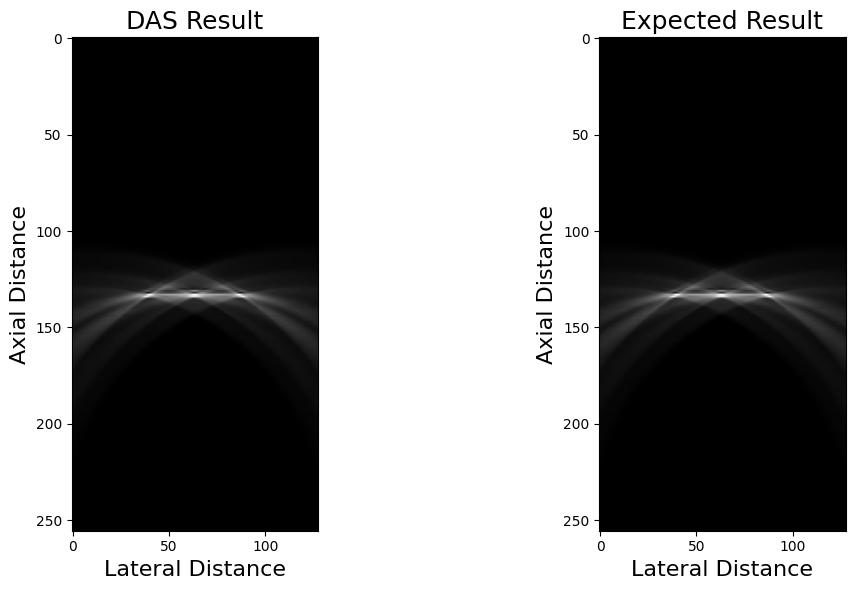

In [10]:
das_result = delay_and_sum()
expected_result = np.load('das_result.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(das_result, cmap='gray')
ax1.set_title('DAS Result', fontsize=18)
ax1.set_xlabel('Lateral Distance', fontsize=16)
ax1.set_ylabel('Axial Distance', fontsize=16)

ax2.imshow(expected_result, cmap='gray')
ax2.set_title('Expected Result', fontsize=18)
ax2.set_xlabel('Lateral Distance', fontsize=16)
ax2.set_ylabel('Axial Distance', fontsize=16)

plt.tight_layout()
plt.show()


## Coherence factor
As you might have noticed, there are artifacts in the reconstructed image. One common approach to reduce this issue is to weight the image using CF (Coherence Factor), which is one of the most common weighting method in beamforming. 
$$CF(k) = \frac{\left| \sum_{i=1}^{M} x_i(k - \Delta_i) \right|^2}{M \sum_{i=1}^{M} |x_i(k - \Delta_i)|^2}$$


In [12]:
def cf():
    cf_factors = np.zeros((256, 128))
    for x in range(128):
        for y in range(256):
            # TODO: Calculate coherence factor weights for each pixel
            # -------------------------------------------------------
            distances = distance_to_transducers(x, y)
            time_delta = get_time_delta_index(distances)
            values = sensor_data[np.arange(128),time_delta]
            cf_factors[y, x] = (values.mean()**2)/(128 * np.power(values, 2).mean())
            # -------------------------------------------------------

    return cf_factors

cf_factors = cf()
cf_das_result = cf_factors*das_result
cf_das_result = (cf_das_result - cf_das_result.min())/(cf_das_result.max() - cf_das_result.min())

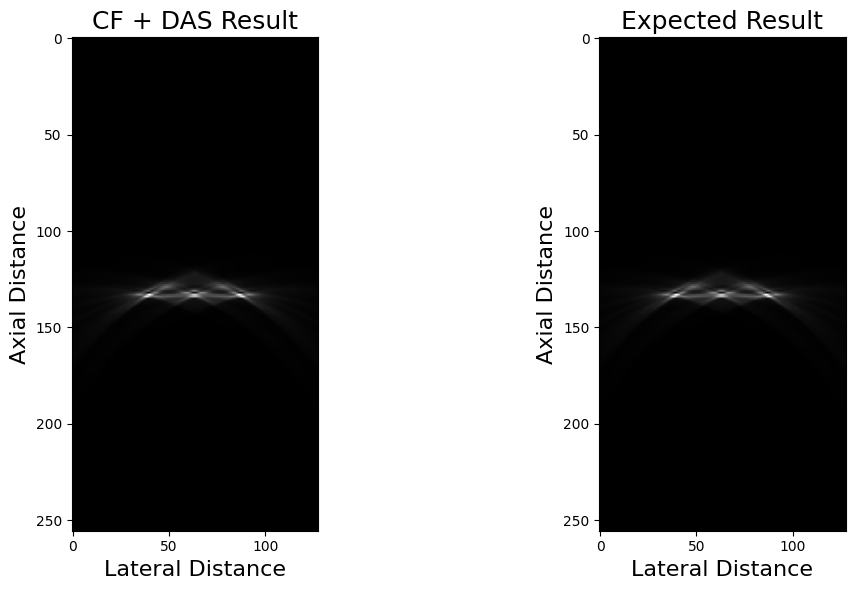

In [15]:
cf_das_expected = np.load('cf_das_result.npy')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(cf_das_result, cmap='gray')
ax1.set_title('CF + DAS Result', fontsize=18)
ax1.set_xlabel('Lateral Distance', fontsize=16)
ax1.set_ylabel('Axial Distance', fontsize=16)

ax2.imshow(cf_das_expected, cmap='gray')
ax2.set_title('Expected Result', fontsize=18)
ax2.set_xlabel('Lateral Distance', fontsize=16)
ax2.set_ylabel('Axial Distance', fontsize=16)

plt.tight_layout()
plt.show()

## Homework Quiz

### The questions that follow aim to help you better understand key ideas related to Radio Telescopes, Interferometry, Tomography, and Tomographic Reconstruction. Please answer to the best of your ability and don't hesitate to use any resources you find helpful.

---

**1. What is the primary function of the parabolic dish in a radio telescope?**

- [ ] A) Amplify radio signals
- [ ] B) Collect and focus radio waves
- [ ] C) Generate radio waves
- [ ] D) Decode radio signals

---

**2. Name a key advantage of using interferometry in radio astronomy.**

- [ ] A) It reduces the cost of building telescopes
- [ ] B) It allows for color imaging of radio waves
- [ ] C) It increases the resolution of the images
- [ ] D) It allows for faster data transmission

---

**3. In Very Long Baseline Interferometry (VLBI), how is the effective diameter of the telescope determined?**

- [ ] A) By the diameter of the largest telescope in the array
- [ ] B) By the sum of the diameters of all telescopes in the array
- [ ] C) By the maximum separation between the telescopes
- [ ] D) By the minimum separation between the telescopes
---
**4. In the context of medical imaging, which one is NOT a common type of wave used in tomography?**

- [ ] A) Ultrasound
- [ ] B) X-rays
- [ ] C) Electromagnetic waves
- [ ] D) Light waves
---
**5. Describe the basic principle behind tomographic reconstruction.**

- [ ] A) Creating a 3D model from a series of 2D images
- [ ] B) Amplifying weak signals to create clearer images
- [ ] C) Generating a holographic display of an object
- [ ] D) Increasing the resolution of images using software enhancements
---
**6. What is the primary function of the Filtered Back Projection (FBP) algorithm in tomographic reconstruction?**

- [ ] A) Creating a 3D model from a series of 2D images
- [ ] B) Amplifying weak signals to create clearer images
- [ ] C) Generating a holographic display of an object
- [ ] D) Increasing the resolution of images using software enhancements
---
**7. Name an iterative reconstruction algorithm used in tomography.**

- [ ] A) Fourier Transform Algorithm
- [ ] B) Filtered Back Projection Algorithm
- [ ] C) Algebraic Reconstruction Technique
- [ ] D) Radon Transformation Algorithm
---
**8. Name an iterative reconstruction algorithm used in tomography.**

- [ ] A) It relates the 2D Fourier transform of the object to the 1D Fourier transform of the projections
- [ ] B) It allows for the conversion of analog signals to digital signals
- [ ] C) It enhances the resolution of the reconstructed images
- [ ] D) It filters out noise from the reconstructed images

---


**Answers:**  
B, C, C, D, A, C, C, A
